<a id="icerik"></a>
## 📘 İçindekiler
- [1. Kütüphanelerin Import Edilmesi ve Veri Yükleme](#import)
- [2. Veri Seti Hakkında Temel Bilgiler ve İlk İnceleme](#veri)
- [3. Eksik Değer Analizi ve Temel Görselleştirmeler](#eksik)
- [4. Aykırı Değer (Outlier) Tespiti - IQR Yöntemi](#outlier)
- [5. Feature Extraction (Özellik Çıkarımı) - Zaman Pencereleri](#feature)
- [6. Feature Dağılımı Görselleştirmesi](#dagilim)
- [7. Veri Standardizasyonu ve Train-Test Split](#split)
- [8. SVM Modeli Kurulumu, Eğitimi ve Performans Ölçümü](#svm)
- [9. SVM Confusion Matrix Görselleştirmesi](#confusion)
- [10. SVM Modeli için GridSearchCV ile Hiperparametre Optimizasyonu](#svm-grid)
- [11. Label Encoding ile Aktivite Kodlama](#encoding)
- [12. XGBoost Modeli Kurulumu, Eğitimi ve Değerlendirmesi](#xgb)
- [13. XGBoost için GridSearchCV ile Hiperparametre Optimizasyonu](#xgb-grid)
- [14. Model Performans Karşılaştırması (Accuracy & F1 Score)](#compare)


<a id="import"></a>
## 1. Kütüphanelerin Import Edilmesi ve Veri Yükleme

In [19]:
# 1. Kütüphaneleri import et
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 2. Veri Yükleme
df = pd.read_csv("time_series_data_human_activities.csv", header=None)  # Dosya adı sizin indirdiğiniz dosya ile aynı olmalı


# 3. Kolon isimleri ekleme
df.columns = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']

df = df.drop(0)  # 0. satırı sil
df.columns = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']


# 4. Temel bilgi
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073623 entries, 1 to 1073623
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1073623 non-null  object
 1   activity   1073623 non-null  object
 2   timestamp  1073623 non-null  object
 3   x          1073623 non-null  object
 4   y          1073623 non-null  object
 5   z          1073623 non-null  object
dtypes: object(6)
memory usage: 49.1+ MB
None


<a id="veri"></a>
## 2. Veri Seti Hakkında Temel Bilgiler ve İlk İnceleme

In [3]:
print(df.describe())

        user_id activity       timestamp           x           y          z
count   1073623  1073623         1073623  1073623.00  1073623.00  1073623.0
unique       37        6          997071     2939.00     2838.00     3882.0
top          20  Walking  19079643380000       -0.89       19.57       -0.0
freq      54294   417901              20     3569.00    15407.00     4149.0


In [4]:
print(df['activity'].value_counts())

activity
Walking       417901
Jogging       324600
Upstairs      122598
Downstairs    100192
Sitting        59939
Standing       48393
Name: count, dtype: int64


In [5]:
print(df.head(10))

   user_id activity      timestamp      x      y      z
1        1  Walking  4991922345000   0.69   10.8  -2.03
2        1  Walking  4991972333000   6.85   7.44   -0.5
3        1  Walking  4992022351000   0.93   5.63   -0.5
4        1  Walking  4992072339000  -2.11   5.01  -0.69
5        1  Walking  4992122358000  -4.59   4.29  -1.95
6        1  Walking  4992172376000  12.41  11.18   7.82
7        1  Walking  4992222333000  17.27   11.6   5.94
8        1  Walking  4992272321000   1.42   8.43  -5.28
9        1  Walking  4992322339000  -2.68  15.89  -0.38
10       1  Walking  4992372327000  -1.38   9.92  -1.99


<a id="eksik"></a>
## 3. Eksik Değer Analizi ve Temel Görselleştirmeler

user_id      0
activity     0
timestamp    0
x            0
y            0
z            0
dtype: int64


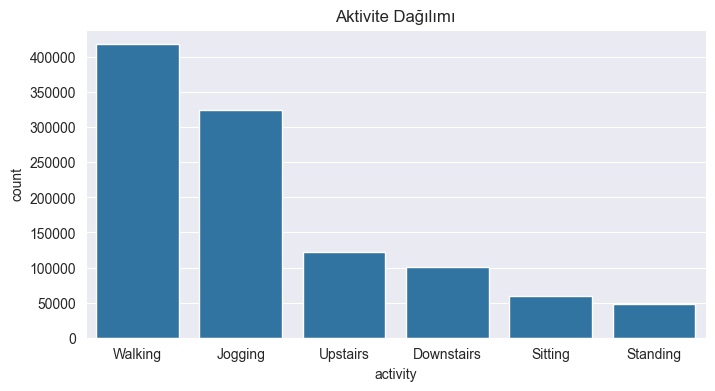

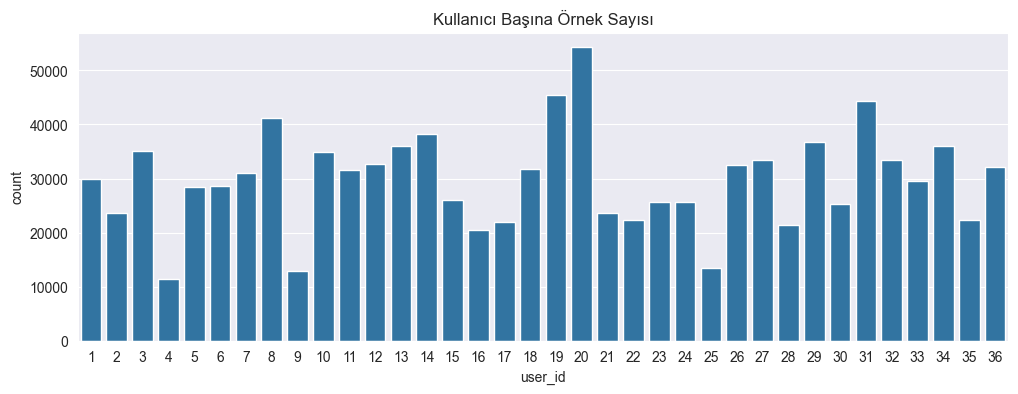

                 x           y          z
count   1073623.00  1073623.00  1073623.0
unique     2939.00     2838.00     3882.0
top          -0.89       19.57       -0.0
freq       3569.00    15407.00     4149.0


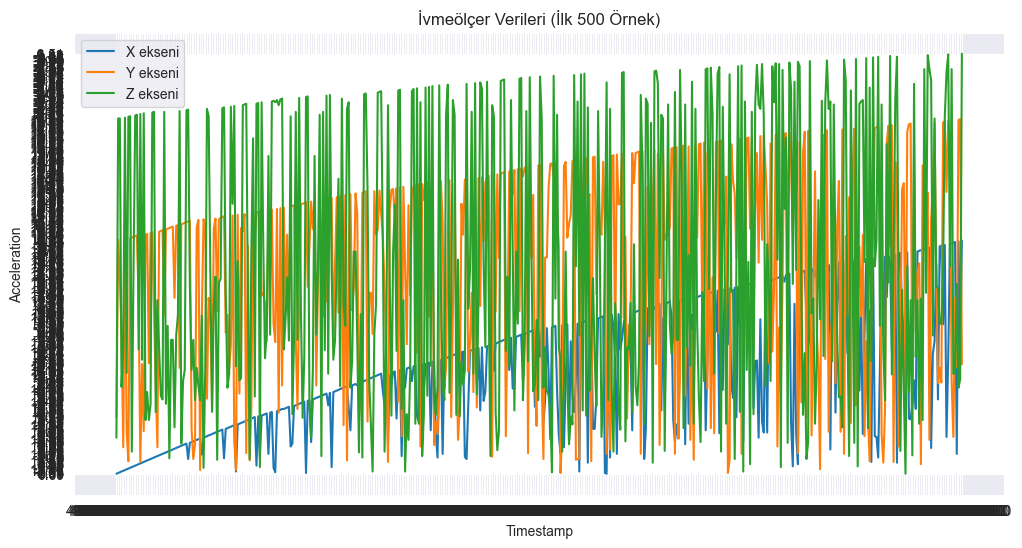

In [6]:
# 5. Eksik değer kontrolü
print(df.isnull().sum())

# 6. Temel dağılım ve sınıf sayısı
plt.figure(figsize=(8,4))
sns.countplot(x='activity', data=df)
plt.title("Aktivite Dağılımı")
plt.show()

# 7. Kullanıcı başına örnek sayısı
plt.figure(figsize=(12,4))
sns.countplot(x='user_id', data=df)
plt.title("Kullanıcı Başına Örnek Sayısı")
plt.show()

# 8. Sensör verilerinin temel istatistikleri
print(df[['x','y','z']].describe())

# 9. Sensör verilerini görselleştirme (örnek: zaman serisi ilk 500 örnek)
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'][:500], df['x'][:500], label='X ekseni')
plt.plot(df['timestamp'][:500], df['y'][:500], label='Y ekseni')
plt.plot(df['timestamp'][:500], df['z'][:500], label='Z ekseni')
plt.title("İvmeölçer Verileri (İlk 500 Örnek)")
plt.xlabel("Timestamp")
plt.ylabel("Acceleration")
plt.legend()
plt.show()


<a id="outlier"></a>
## 4. Aykırı Değer (Outlier) Tespiti - IQR Yöntemi

In [8]:
# Sütunları float yap
df[['x','y','z']] = df[['x','y','z']].astype(float)

# Tekrar IQR yöntemi
Q1 = df[['x','y','z']].quantile(0.25)
Q3 = df[['x','y','z']].quantile(0.75)
IQR = Q3 - Q1

df_clean_iqr = df[~((df[['x','y','z']] < (Q1 - 1.5 * IQR)) | (df[['x','y','z']] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"IQR ile temizlenmiş veri boyutu: {df_clean_iqr.shape}")


IQR ile temizlenmiş veri boyutu: (957062, 6)


<a id="feature"></a>
## 5. Feature Extraction (Özellik Çıkarımı) - Zaman Pencereleri

In [9]:
window_size = 50  # örnek sayısı (2 saniyelik pencere gibi düşünebilirsin)
step_size = 25    # kaydırma miktarı

features = []
labels = []

for start in range(0, len(df_clean_iqr) - window_size, step_size):
    end = start + window_size
    window = df_clean_iqr.iloc[start:end]
    
    x = window['x'].astype(float)
    y = window['y'].astype(float)
    z = window['z'].astype(float)
    
    feat = [
        x.mean(), x.std(), x.max(), x.min(),
        y.mean(), y.std(), y.max(), y.min(),
        z.mean(), z.std(), z.max(), z.min(),
        np.sqrt((x**2 + y**2 + z**2).sum())  # enerji
    ]
    
    features.append(feat)
    # Pencere etiketini en çok tekrar eden aktivite olarak al
    labels.append(window['activity'].mode()[0])

# Feature DataFrame oluştur
X = pd.DataFrame(features, columns=[
    'x_mean','x_std','x_max','x_min',
    'y_mean','y_std','y_max','y_min',
    'z_mean','z_std','z_max','z_min',
    'energy'
])
y = pd.Series(labels)


<a id="dagilim"></a>
## 6. Feature Dağılımı Görselleştirmesi

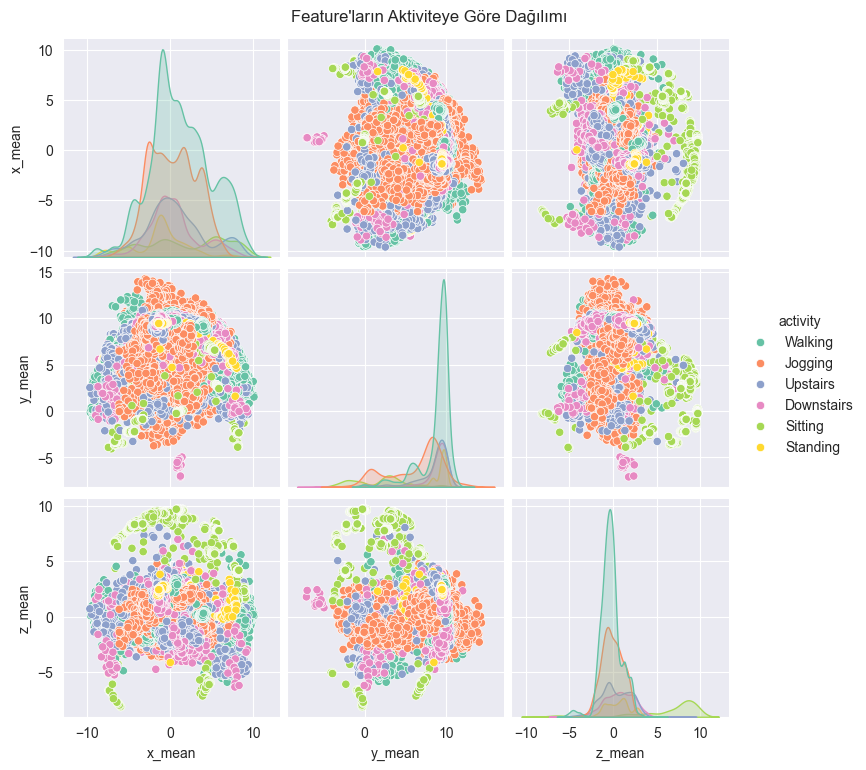

In [10]:
# Örnek olarak ilk 4 feature'u ve hedefi kullan
plot_data = X[['x_mean', 'y_mean', 'z_mean']].copy()
plot_data['activity'] = y

# Pairplot ile görselleştirme
sns.pairplot(plot_data, hue='activity', diag_kind='kde', palette='Set2')
plt.suptitle("Feature'ların Aktiviteye Göre Dağılımı", y=1.02)
plt.show()

<a id="split"></a>
## 7. Veri Standardizasyonu ve Train-Test Split

In [11]:

# Standardizasyon (özellikle SVM için)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train boyutu: {X_train.shape}, Test boyutu: {X_test.shape}")

Train boyutu: (30624, 13), Test boyutu: (7657, 13)


<a id="svm"></a>
## 8. SVM Modeli Kurulumu, Eğitimi ve Performans Ölçümü

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# SVM modeli tanımla
svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)  # C ve gamma başlangıç değerleri

# Eğit
svm_model.fit(X_train, y_train)

# Tahmin yap
y_pred = svm_model.predict(X_test)

# Performans ölçümü
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9100169779286927

Classification Report:
               precision    recall  f1-score   support

  Downstairs       0.80      0.68      0.74       771
     Jogging       0.97      0.98      0.97      1911
     Sitting       1.00      0.98      0.99       479
    Standing       0.98      0.99      0.98       387
    Upstairs       0.82      0.66      0.74       939
     Walking       0.90      0.98      0.94      3170

    accuracy                           0.91      7657
   macro avg       0.91      0.88      0.89      7657
weighted avg       0.91      0.91      0.91      7657



<a id="confusion"></a>
## 9. SVM Confusion Matrix Görselleştirmesi

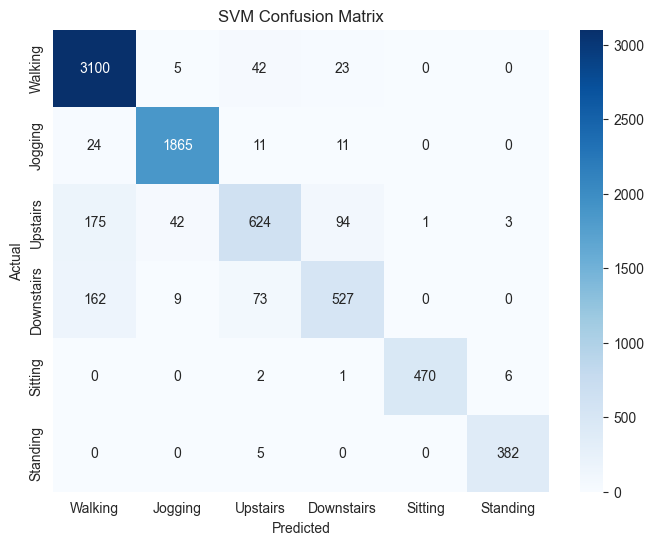

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

cm = confusion_matrix(y_test, y_pred, labels=y.unique())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y.unique(), yticklabels=y.unique(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()


<a id="svm-grid"></a>
## 10. SVM Modeli için GridSearchCV ile Hiperparametre Optimizasyonu

In [16]:
from sklearn.model_selection import GridSearchCV

# Parametre aralıkları
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# GridSearchCV
grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

# En iyi parametreler
print("En iyi parametreler:", grid.best_params_)

# Tahmin ve performans
y_pred_grid = grid.predict(X_test)
print("GridSearch Accuracy:", accuracy_score(y_test, y_pred_grid))
print("\nClassification Report:\n", classification_report(y_test, y_pred_grid))
svm_acc = accuracy_score(y_test, y_pred_grid)
svm_f1 = f1_score(y_test, y_pred_grid, average='weighted')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
En iyi parametreler: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
GridSearch Accuracy: 0.9396630534151756

Classification Report:
               precision    recall  f1-score   support

  Downstairs       0.84      0.80      0.82       771
     Jogging       0.97      0.99      0.98      1911
     Sitting       1.00      0.97      0.98       479
    Standing       0.99      0.98      0.99       387
    Upstairs       0.85      0.83      0.84       939
     Walking       0.96      0.97      0.96      3170

    accuracy                           0.94      7657
   macro avg       0.93      0.92      0.93      7657
weighted avg       0.94      0.94      0.94      7657



<a id="encoding"></a>
## 11. Label Encoding ile Aktivite Kodlama

In [17]:
from sklearn.preprocessing import LabelEncoder

# Label encoder oluştur
le = LabelEncoder()

# y'yi encode et
y_encoded = le.fit_transform(y)

# Veriyi tekrar train-test ayır
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


<a id="xgb"></a>
## 12. XGBoost Modeli Kurulumu, Eğitimi ve Değerlendirmesi

XGBoost Accuracy: 0.9345696748073659

Classification Report:
               precision    recall  f1-score   support

  Downstairs       0.85      0.74      0.79       766
     Jogging       0.98      0.98      0.98      1867
     Sitting       0.99      0.99      0.99       468
    Standing       0.99      0.98      0.98       401
    Upstairs       0.88      0.78      0.83       948
     Walking       0.93      0.98      0.95      3207

    accuracy                           0.93      7657
   macro avg       0.94      0.91      0.92      7657
weighted avg       0.93      0.93      0.93      7657



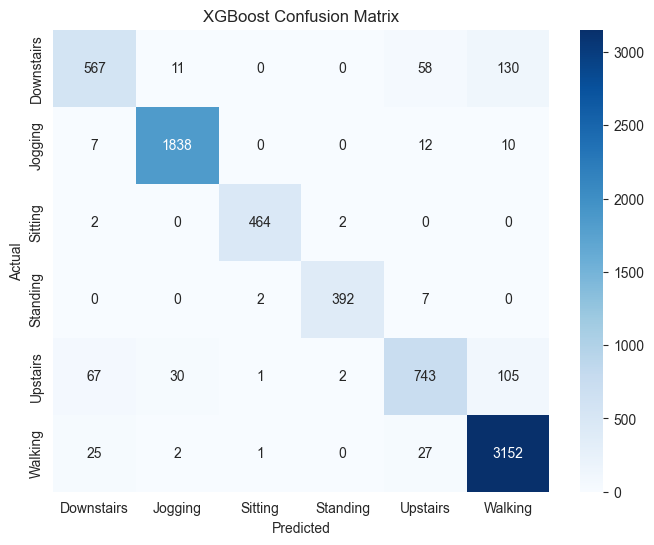

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Model oluştur
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Eğit
xgb_model.fit(X_train, y_train)

# Tahmin
y_pred_xgb = xgb_model.predict(X_test)

# Accuracy
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<a id="xgb-grid"></a>
## 13. XGBoost için GridSearchCV ile Hiperparametre Optimizasyonu

In [21]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False
)

grid_xgb = GridSearchCV(xgb, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("En iyi parametreler:", grid_xgb.best_params_)
print("En iyi skor:", grid_xgb.best_score_)

# En iyi modelle test et
best_xgb = grid_xgb.best_estimator_
y_pred_best = best_xgb.predict(X_test)

xgb_acc = accuracy_score(y_test, y_pred_best)

print("Tuned XGBoost Accuracy:", xgb_acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best, target_names=le.classes_))


xgb_f1 = f1_score(y_test, y_pred_best, average='weighted')

Fitting 3 folds for each of 72 candidates, totalling 216 fits
En iyi parametreler: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
En iyi skor: 0.9333529258098223
Tuned XGBoost Accuracy: 0.942797440250751

Classification Report:
               precision    recall  f1-score   support

  Downstairs       0.88      0.79      0.83       766
     Jogging       0.98      0.98      0.98      1867
     Sitting       0.99      0.99      0.99       468
    Standing       0.99      0.98      0.98       401
    Upstairs       0.89      0.81      0.85       948
     Walking       0.94      0.98      0.96      3207

    accuracy                           0.94      7657
   macro avg       0.94      0.92      0.93      7657
weighted avg       0.94      0.94      0.94      7657



<a id="compare"></a>
## 14. Model Performans Karşılaştırması (Accuracy & F1 Score)

     Model  Accuracy  F1 Score
0      SVM  0.939663  0.939100
1  XGBoost  0.942797  0.941465


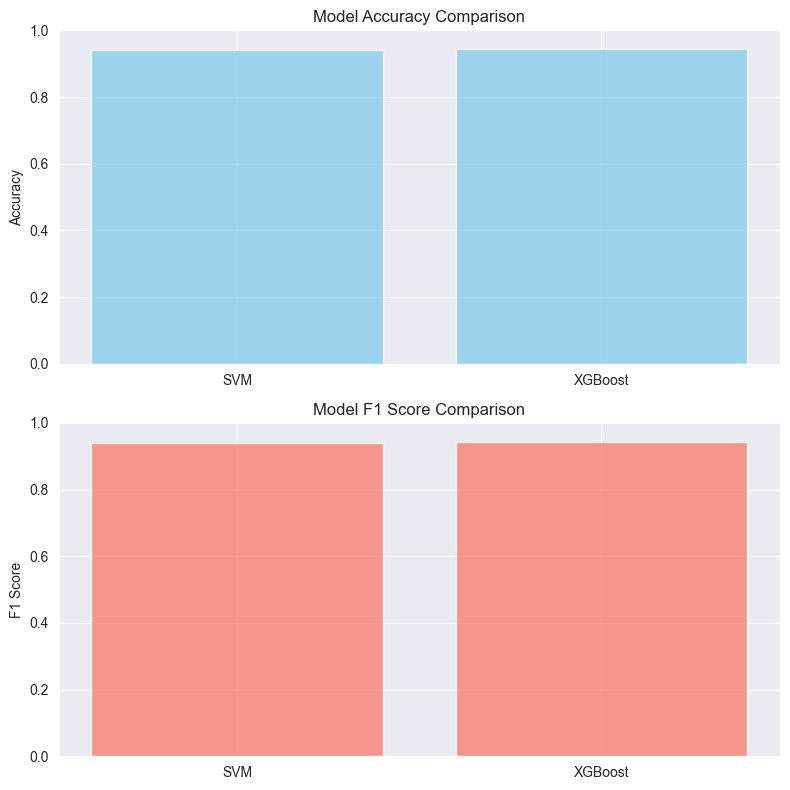

In [23]:
# Tablo oluştur
results = pd.DataFrame({
    'Model': ['SVM', 'XGBoost'],
    'Accuracy': [svm_acc, xgb_acc],
    'F1 Score': [svm_f1, xgb_f1]
})

print(results)

# Görselleştirme
# Görselleştirme
fig, axes = plt.subplots(2, 1, figsize=(8, 8))  # 2 row, 1 column

# Accuracy karşılaştırması
axes[0].bar(results['Model'], results['Accuracy'], color='skyblue', alpha=0.8)
axes[0].set_title("Model Accuracy Comparison")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0, 1)

# F1 Score karşılaştırması
axes[1].bar(results['Model'], results['F1 Score'], color='salmon', alpha=0.8)
axes[1].set_title("Model F1 Score Comparison")
axes[1].set_ylabel("F1 Score")
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()
